In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import json
import pickle

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
with open("../utils/columns.json", 'rb') as file:
    column_names = json.load(file)['trainTestColumns']

In [5]:
column=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]

In [6]:
train=pd.read_csv("../data/train_FD001.txt",sep=" ",names=column)

In [7]:
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('engine')['cycle'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['engine','max']
    df = df.merge(fd_RUL, on=['engine'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop(columns=['max'],inplace = True)
    return df[df['cycle'] > factor]

In [8]:
test=pd.read_csv("../data/test_FD001.txt",sep=" ",names=column)
test_results=pd.read_csv("../data/RUL_FD001.txt",sep=" ",header=None)

test_results.columns=["rul","null"]
test_results.drop(["null"],axis=1,inplace=True)
test_results['id']=test_results.index+1
rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']

test_results['rul_failed']=test_results['rul']+rul['max']
test_results.drop(["rul"],axis=1,inplace=True)

test=test.merge(test_results,on=['id'],how='left')
test["RUL"]=test["rul_failed"]-test["cycle"]
test.drop(columns=['rul_failed'], inplace=True)

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
te_null_df = pd.DataFrame(test.isnull().sum()).T
te_null_df[te_null_df > 0].dropna(axis=1) # Showing only column with values other than 0

sensor22  sensor23
0     13096     13096

In [11]:
tr_null_df = pd.DataFrame(train.isnull().sum()).T
tr_null_df[tr_null_df > 0].dropna(axis=1) # Showing only column with values other than 0

sensor22  sensor23
0     20631     20631

In [12]:
null_cols = ["sensor22","sensor23"]

In [13]:
#Dropping null columns
df_train=train.drop(null_cols,axis=1)
df_train.columns = column_names
df_train = prepare_train_data(df_train)

df_test=test.drop(null_cols,axis=1)
df_test.columns = column_names+['RUL']

In [14]:
train_end = int(len(df_train)*0.9)

In [15]:
sensor_cols = [col for col in df_train.columns if col not in ['RUL', 'engine', 'cycle']]

In [16]:
uniq_val_col = []
for col in sensor_cols:
    if df_train[col].nunique() ==1:
        uniq_val_col.append(col)

In [17]:
uniq_val_col

['setting_3',
 'Fan_inlet_temperature_R',
 'Fan_inlet_Pressure_psia',
 'Engine_pressure_ratioP50_P2',
 'Burner_fuel_air_ratio',
 'Required_fan_speed',
 'Required_fan_conversion_speed']

In [18]:
sensor_cols = [col for col in sensor_cols if col not in uniq_val_col]

In [19]:
linear_corr = df_train[sensor_cols].corr(method='pearson')
nonlinear_corr_spearman = df_train.corr(method='spearman')

In [20]:
def high_corr_col(linear_corr):
    threshold = 0.85

    # Identify columns to drop based on Pearson correlation
    high_corr = np.where(abs(linear_corr) > threshold)
    high_corr_pairs = [(linear_corr.index[x], linear_corr.columns[y]) for x, y in zip(*high_corr) if x != y]
    high_corr_pairs = [tuple(sorted(tup, key=lambda x: x[0])) for tup in high_corr_pairs]
    high_corr_pairs = list(set(high_corr_pairs))

    # Track columns to drop, avoiding duplicates
    to_drop = set()
    for (col1, col2) in high_corr_pairs:
        to_drop.add(col1 if col1 not in to_drop else col2)

    print("Columns dropped:", to_drop)
    return list(to_drop)

In [21]:
lin_col_to_drop = high_corr_col(linear_corr)
non_lin_col_to_drop = high_corr_col(nonlinear_corr_spearman)

Columns dropped: {'Corrected_core_speed_rpm'}
Columns dropped: {'Corrected_core_speed_rpm'}


In [22]:
df_train.drop(columns= lin_col_to_drop+uniq_val_col, inplace=True)
df_test.drop(columns= lin_col_to_drop+uniq_val_col, inplace=True)

In [23]:
# df_test.to_csv("../data/test_data2.csv", index=False)

In [24]:
exo_col = [col for col in df_train.columns if col not in ['RUL']]
endo_col = ['RUL']

In [25]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train, y_train = scaler_x.fit_transform(df_train[exo_col][:train_end]), scaler_y.fit_transform(df_train[['RUL']][:train_end]) 
x_val, y_val  =  scaler_x.transform(df_train[exo_col][train_end:]), scaler_y.transform(df_train[['RUL']][train_end:])
x_test, y_test = scaler_x.transform(df_test[exo_col]), df_test[['RUL']].values

In [26]:
# with open("scaler_y2.pkl", "wb") as file:
#     pickle.dump(scaler_y, file)
# with open("./scaler_x2.pkl", "wb") as file:
#     pickle.dump(scaler_x, file)

In [27]:
# # Without scaling (Splitting train and val as we do it for scaling case)
# x_train, y_train = df_train[exo_col][:train_end].values, df_train[['RUL']][:train_end].values
# x_val, y_val  =  df_train[exo_col][train_end:].values, df_train[['RUL']][train_end:].values

# x_test, y_test = df_test[exo_col].values, df_test[['RUL']].values

In [28]:
# Function to create sequences
def create_sequences(data, target_col, window_size):
    X_seq, y_seq = [], []    
    for i in range(len(data) - window_size):
        X_seq.append(data.iloc[i:i+window_size].drop(columns=[target_col]).values)
        # X_seq.append(data.iloc[i:i+window_size].values)
        y_seq.append(data.iloc[i+window_size][target_col])
    return np.array(X_seq), np.array(y_seq)

In [29]:
# df_test.drop(columns = ['RUL']).to_csv("../data/test_data.csv", index= False)
# df_test[['RUL']].to_csv("../data/test_data_rul.csv", index= False)

In [30]:
window_size = x_train.shape[-1] #20 #10
df_train_scaled = pd.DataFrame((np.concatenate((x_train, x_val), axis=0)), columns= exo_col)
df_train_scaled['Target'] = np.concatenate((y_train,y_val), axis= 0)
x_train_seq, y_train_seq = create_sequences(df_train_scaled, 'Target', window_size)

In [31]:
df_test_scaled = pd.DataFrame((x_test), columns= exo_col)
df_test_scaled['Target'] = y_test
x_test_seq, y_test_seq = create_sequences(df_test_scaled, 'Target', window_size)

In [32]:
import torch
from torch.utils.data import DataLoader, TensorDataset
batch_size = 64

#Train and val data loader
X_train_tensor = torch.tensor(x_train_seq[:train_end], dtype = torch.float32, device=device)
y_train_tensor = torch.tensor(y_train_seq[:train_end], dtype= torch.float32, device=device)

X_val_tensor = torch.tensor(x_train_seq[train_end:], dtype = torch.float32, device=device)
y_val_tensor = torch.tensor(y_train_seq[train_end:]  , dtype= torch.float32, device=device)

# test data loader
X_test_tensor = torch.tensor(x_test_seq, dtype = torch.float32, device=device)
y_test_tensor = torch.tensor(y_test_seq, dtype= torch.float32, device=device)

traindataset = TensorDataset(X_train_tensor, y_train_tensor) 
valdataset = TensorDataset(X_val_tensor, y_val_tensor) 

train_loader = DataLoader(traindataset, batch_size=batch_size, shuffle=False) 
val_loader = DataLoader(valdataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor) 
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [33]:
def evaluate(y_true, y_pred):
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}')
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.2f}')
    print(f'r2 score: {r2_score(y_true, y_pred):.2f}')
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Create a mask for non-zero actual values
    act_non_zero_mask = y_true != 0

    # Create a mask for non-zero pred values
    pred_non_zero_mask = y_pred != 0

    # Ensure that there are non-zero actual values
    if not np.any(act_non_zero_mask):
        raise ValueError("All actual values are zero, MAPE is undefined.")
    if not np.any(pred_non_zero_mask):
        raise ValueError("All pred values are zero, MAPE will be 100%.")

    # Calculate MAPE
    non_zero_mask = np.logical_and(act_non_zero_mask, pred_non_zero_mask)
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]

    # abs_percentage_error = np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])
    abs_percentage_error = np.abs((y_true - y_pred) / y_true)
    mape = np.mean(abs_percentage_error) * 100
    print(f'MAPE: {mape:.2f}')

In [34]:
def plot_result(y_actual, y_pred):
    plt.figure(figsize= (20, 5))
    plt.plot(y_actual, label='actual', color = 'blue')
    plt.plot(y_pred, label= 'prediction', color='orange' )
    plt.legend()
    plt.show()

In [35]:
class EarlyStopping:
    def __init__(self, patience = 10, delta = 0):
        self.patience = patience
        self.delta = delta
        self.best_score = np.inf 
        self.early_stop = False
        self.counter = 0 

    def __call__(self, val_loss):
        '''
        If the loss is decreasing atlease by 0.001 continue and make counter 0, or increase the counter till patience value.
        '''
        score = val_loss
        if self.best_score - score > self.delta:
            self.best_score = score
            self.counter = 0
        else:
            self.counter +=1
            if self.counter >= self.patience:
                self.early_stop = True
patience = 15
# early_stopping = EarlyStopping(patience=15, delta=0.01)
early_stopping = EarlyStopping(patience=15, delta=0.001)
# early_stopping = EarlyStopping(patience=20, delta=0.001)

DeFormer model

In [36]:
x_train.shape[-1] 

18

In [37]:
# from deformer_model import DEformer

# # Hyperparameters
# input_dim = x_train.shape[-1]        # Number of features
# seq_len = x_train.shape[-1]             # Sequence length
# embed_dim = 32# 64                       # Embedding dimension
# num_heads = 2 #4                        # Number of attention heads
# num_layers = 2        # Number of Transformer layers in each encoder
# output_dim = 1        # Output dimension for forecasting


# # Instantiate and test model
# # model = DEformer(input_dim=16, embed_dim=64, num_heads=4, num_layers=2, output_dim=1, seq_len=20)
# model = DEformer(input_dim, embed_dim, num_heads, num_layers, output_dim, seq_len)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001) 
# criterion = nn.MSELoss()
# model_name = 'deformer'

CNN model

In [38]:
# from cnn_model import CNNModel

# hidden_dim = 128
# batch_size = 64 #32
# input_dim = x_train.shape[-1]
# kernel_size = 3
# model = CNNModel(input_dim, window_size, hidden_dim=hidden_dim,kernel_size=kernel_size, device=device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001) 
# criterion = nn.MSELoss()
# model_name = 'tdcnn'

TDCNN + SEBlock

In [39]:
from TDCNN_model import FPCASETCN
# from tdcnn2_model import FPCASETCN

# Example training loop with batches
# model = FPCASETCN(x_train.shape[-1], [64, 128, 256])  
model = FPCASETCN(x_train.shape[-1], [64, 128]) 
# model = FPCASETCN(x_train.shape[-1], [64])  
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) #Best [64,128]
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #, weight_decay=1e-3) 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #2Best [[64, 128]
model_name = 'tdcnn_se'


In [40]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [41]:
# Training loop
train_losses = []
val_losses = []
gradient_norms = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:   
        optimizer.zero_grad()
        # if model_name == 'tdcnn_se':
        inputs = inputs.permute(0, 2, 1)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        # Collect gradients norms
        norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
        gradient_norms.append(np.mean(norms))  # Store the mean norm of gradients. This ran for 1550 element (len(train_loader)) as we are taking mean than for 8 epochs.

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:  
            inputs = torch.permute(inputs, (0, 2, 1))
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Check early stopping
    early_stopping(val_loss)
    
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Update the learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\torch\nn\modules\conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([62])) that is different to the input size (torch.Size([62, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.

In PyTorch, for a Conv1d layer, the weight shape is (out_channels, in_channels, kernel_size). 

In your model:
out_channels = 128

in_channels = 26

kernel_size = 3

So, the weight tensor shape for conv1 is (128, 26, 3).

In [42]:
def weight_importance_first_layer(model):
    first_layer_weights = next(model.parameters())  # Get weights from the first layer
    # Mean absolute weight per input feature across output channels and kernel size
    importance = first_layer_weights.abs().mean(dim=(0, 2))
    return importance  # Output shape will be (26,)

In [43]:
# importance = weight_importance_first_layer(model)
# importance

In [44]:
def predict(model, dataloader, device='cpu', model_name=None):
    model.to(device)  # Move model to the appropriate device (CPU or GPU)
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    with torch.no_grad():  # Disable gradient calculation for inference
        for inputs, _ in dataloader:  # Assuming dataloader returns (inputs, targets)
            if model_name in ['TDCNN', 'DFormer']:
                inputs = torch.permute(inputs, (0, 2, 1))
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_predictions.append(outputs.cpu())  # Move to CPU and collect predictions
    return torch.cat(all_predictions, dim=0)  #

In [45]:
y_test_pred = predict(model, test_loader,device= device, model_name= 'TDCNN')
y_train_pred = predict(model, train_loader,device= device, model_name= 'TDCNN')

torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.Size([64, 128, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18])
torch.Size([64, 64, 18]) torch.Size([64, 64, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18])
torch.Size([64, 128, 18]) torch.

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar(y_train_inv, y_train_pred_inv):
    # Check if lengths of the actual and predicted RUL match
    if len(y_train_inv) != len(y_train_pred_inv):
        raise ValueError("The lengths of actual RUL and predicted RUL must be the same.")
    
    # Convert to numpy arrays if they are pandas Series or DataFrame
    y_train_inv = np.array(y_train_inv) if isinstance(y_train_inv, (pd.Series, pd.DataFrame)) else y_train_inv
    y_train_pred_inv = np.array(y_train_pred_inv) if isinstance(y_train_pred_inv, (pd.Series, pd.DataFrame)) else y_train_pred_inv

    # Set the width of the bars
    bar_width = 0.35

    # Set the positions of the bars on the X-axis (assuming the length of y_train_inv is the number of samples)
    index = range(len(y_train_inv))  # Generate the index for the x-axis based on the number of samples

    # Create the plot
    plt.figure(figsize=(12, 6))  # Adjust figure size if necessary
    plt.bar(index, y_train_inv, width=bar_width, label='Actual RUL', alpha=0.7)
    plt.bar([i + bar_width for i in index], y_train_pred_inv, width=bar_width, label='Predicted RUL', alpha=0.7)

    # Labeling the plot
    plt.xlabel('Sample Index')
    plt.ylabel('RUL')
    plt.title('Comparison of Actual vs Predicted RUL')

    # Limit the number of x-ticks to 10 by selecting 10 evenly spaced index positions
    num_ticks = 10
    tick_positions = np.linspace(0, len(index)-1, num_ticks, dtype=int)
    tick_labels = [str(i) for i in tick_positions]  # Create string labels for the x-ticks

    # Set the x-ticks
    plt.xticks(tick_positions, tick_labels, rotation=45)  # Rotate labels for clarity
    
    plt.legend()

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()

dformer

In [47]:
# with open("../model/DFormer_model.pkl", "wb") as file:
#     pickle.dump(model, file)

*********Train*********
RMSE: 55.37
MAE: 42.34
r2 score: 0.33
MAPE: 220.02


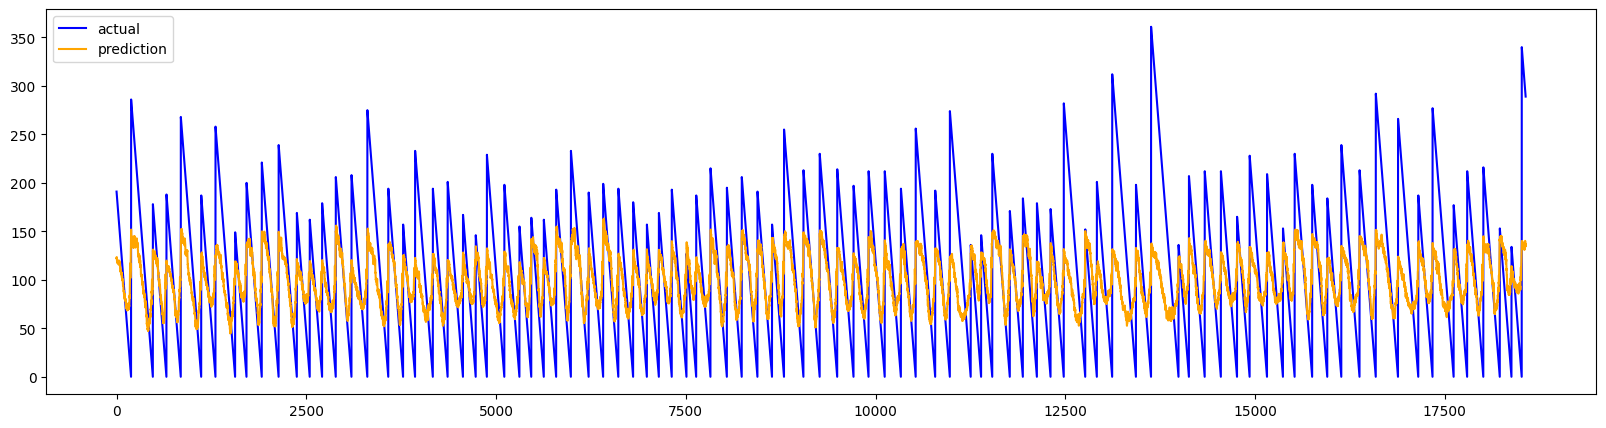

************Test**************
RMSE: 58.39
MAE: 43.94
r2 score: 0.02
MAPE: 35.96


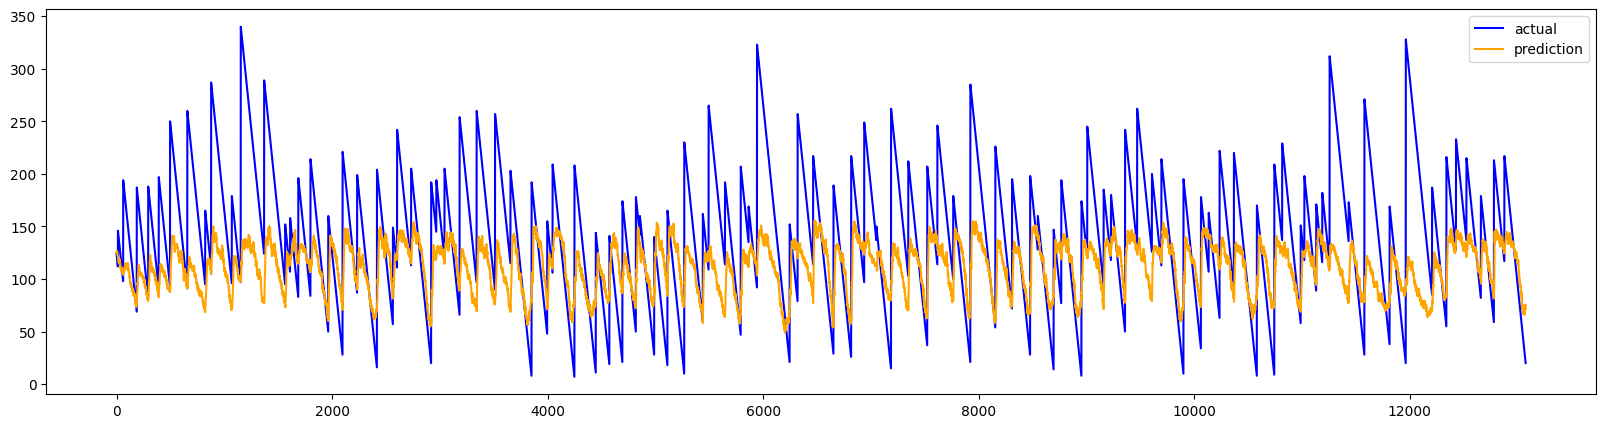

In [46]:
# with open("../model/tdcnn_se_model.pkl", "rb") as file:
#     model_pkl = pickle.load(file)
print("*********Train*********")
y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
y_train_inv = scaler_y.inverse_transform(y_train)
evaluate(y_train_inv, y_train_pred_inv)
plot_result(y_train_inv, y_train_pred_inv)

print("************Test**************")
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
evaluate(y_test[window_size:], y_test_pred_inv)
plot_result(y_test[window_size:], y_test_pred_inv)

C:\Users\PriyamJha\AppData\Local\Temp\ipykernel_11940\2869075175.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust layout to prevent label overlap
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


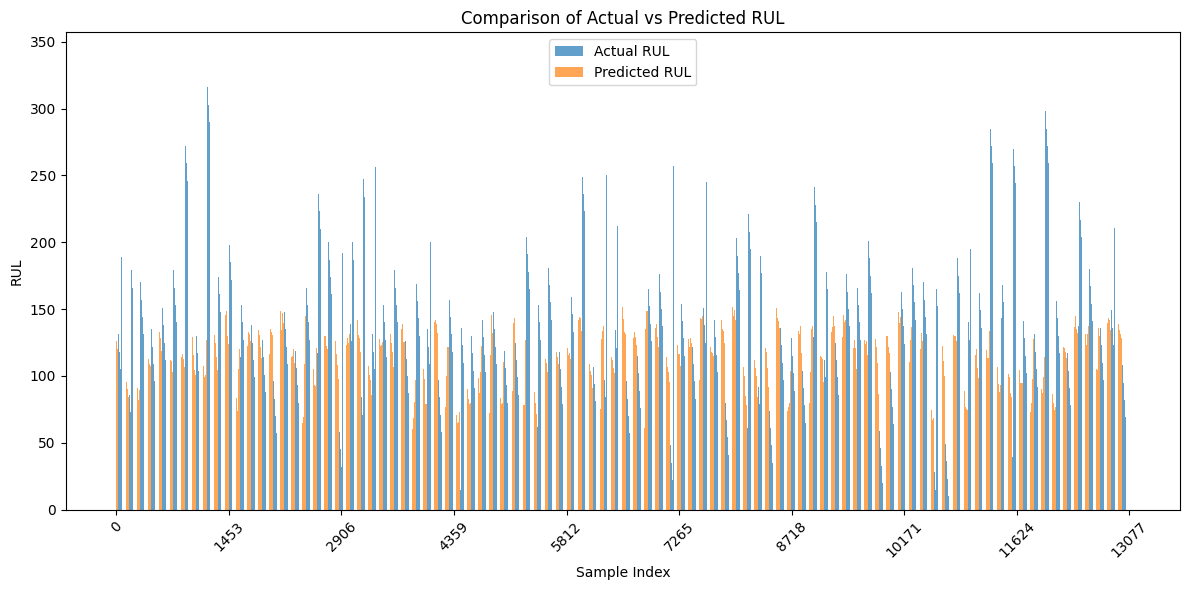

In [66]:
plot_bar(y_test[window_size:].squeeze(), y_test_pred_inv.squeeze())

C:\Users\PriyamJha\AppData\Local\Temp\ipykernel_11940\2869075175.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust layout to prevent label overlap
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


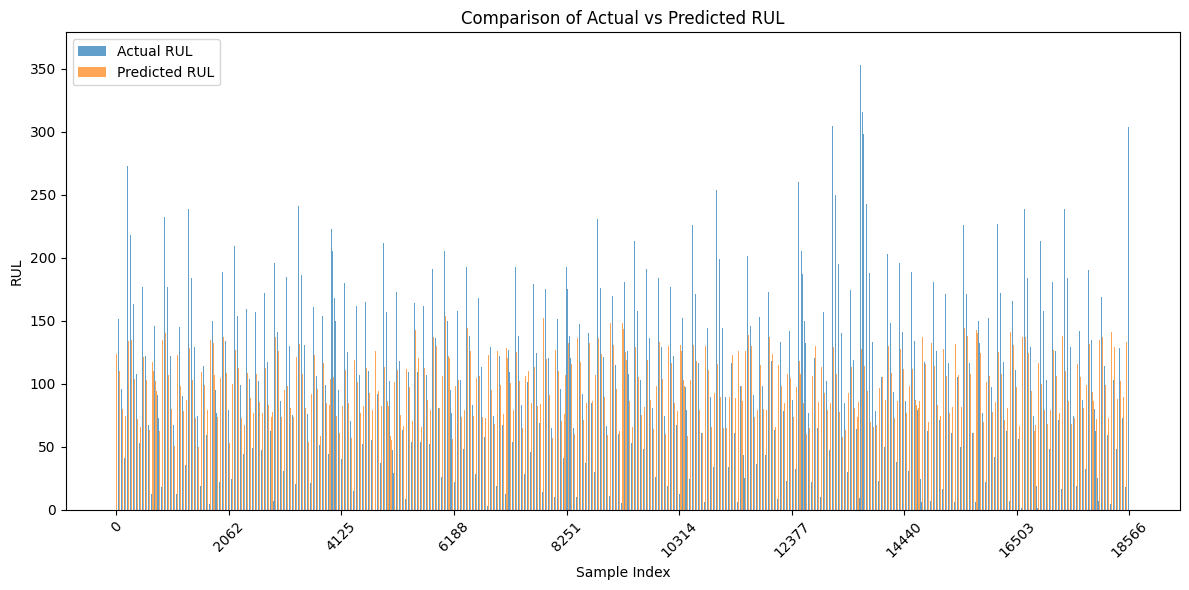

In [65]:
plot_bar(y_train_inv.squeeze(), y_train_pred_inv.squeeze())

tdcnn + SE

In [49]:
len(y_test), len(y_test_pred), len(y_train), len(y_train_pred)

(13096, 13078, 18567, 18567)

train


C:\Users\PriyamJha\AppData\Local\Temp\ipykernel_15096\2869075175.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust layout to prevent label overlap
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


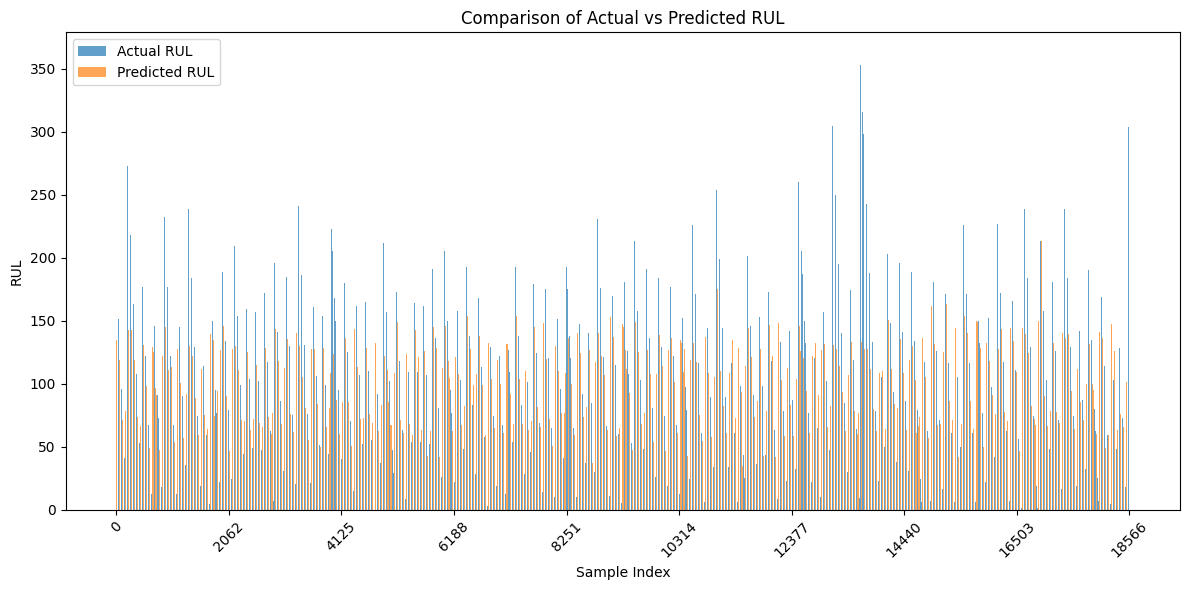

Test


C:\Users\PriyamJha\AppData\Local\Temp\ipykernel_15096\2869075175.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust layout to prevent label overlap
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


In [49]:
print("train")
plot_bar(y_train_inv.squeeze(), y_train_pred_inv.squeeze())
print("Test")
plot_bar(y_test[window_size:].squeeze(), y_test_pred_inv.squeeze())

In [48]:
print("*********Train*********")
y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
y_train_inv = scaler_y.inverse_transform(y_train)
evaluate(y_train_inv, y_train_pred_inv)
plot_result(y_train_inv, y_train_pred_inv)

print("************Test**************")
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
evaluate(y_test[window_size:], y_test_pred_inv)
plot_result(y_test[window_size:], y_test_pred_inv)

*********Train*********
RMSE: 51.43
MAE: 37.80
r2 score: 0.42
MAPE: 228.08


************Test**************
RMSE: 56.14
MAE: 42.38
r2 score: 0.10
MAPE: 34.28


*********Train*********
RMSE: 54.71
MAE: 40.81
r2 score: 0.34
MAPE: 236.00


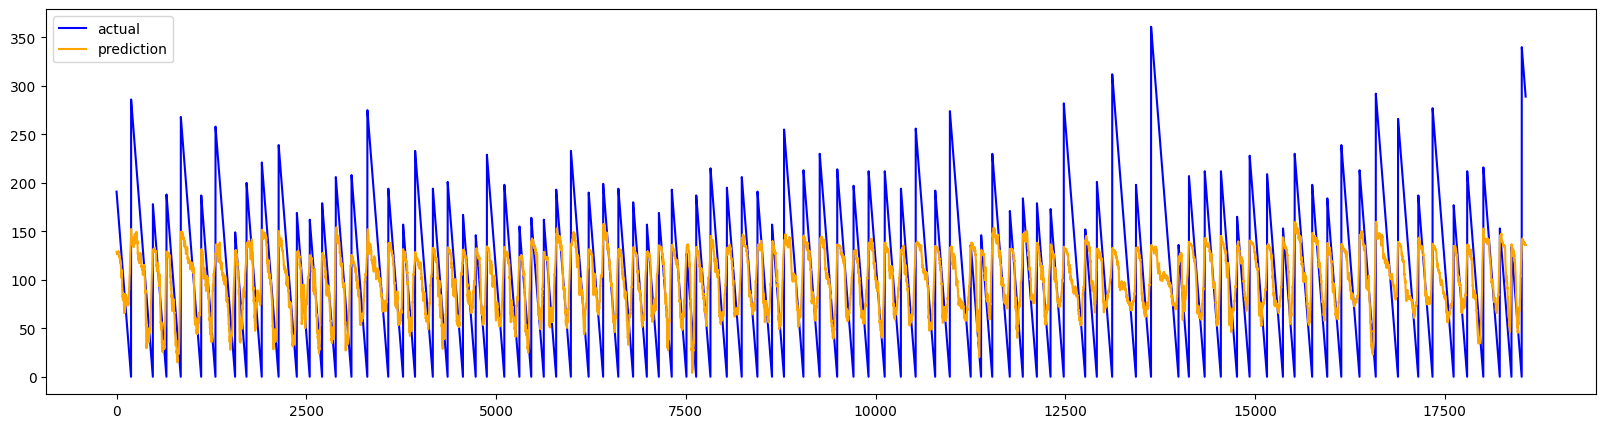

************Test**************
RMSE: 56.73
MAE: 42.11
r2 score: 0.08
MAPE: 34.06


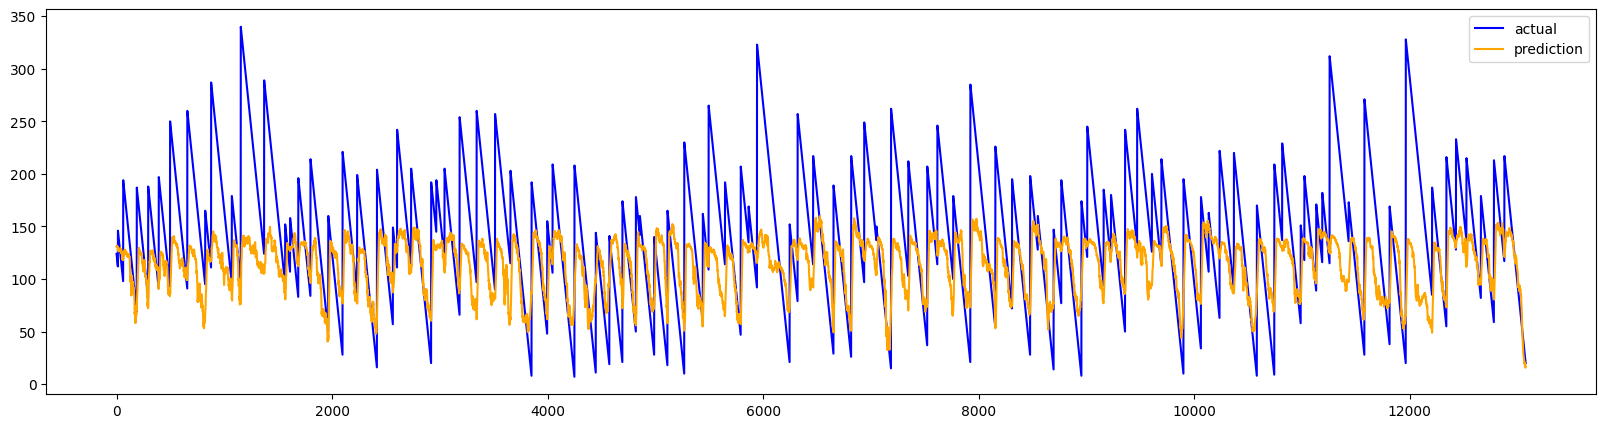

In [48]:
print("*********Train*********")
y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
y_train_inv = scaler_y.inverse_transform(y_train)
evaluate(y_train_inv, y_train_pred_inv)
plot_result(y_train_inv, y_train_pred_inv)

print("************Test**************")
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
evaluate(y_test[window_size:], y_test_pred_inv)
plot_result(y_test[window_size:], y_test_pred_inv)

[64,128] lr: 0.005

**********Train**********
RMSE: 52.14
MAE: 38.48
r2 score: 0.40
MAPE: 222.87


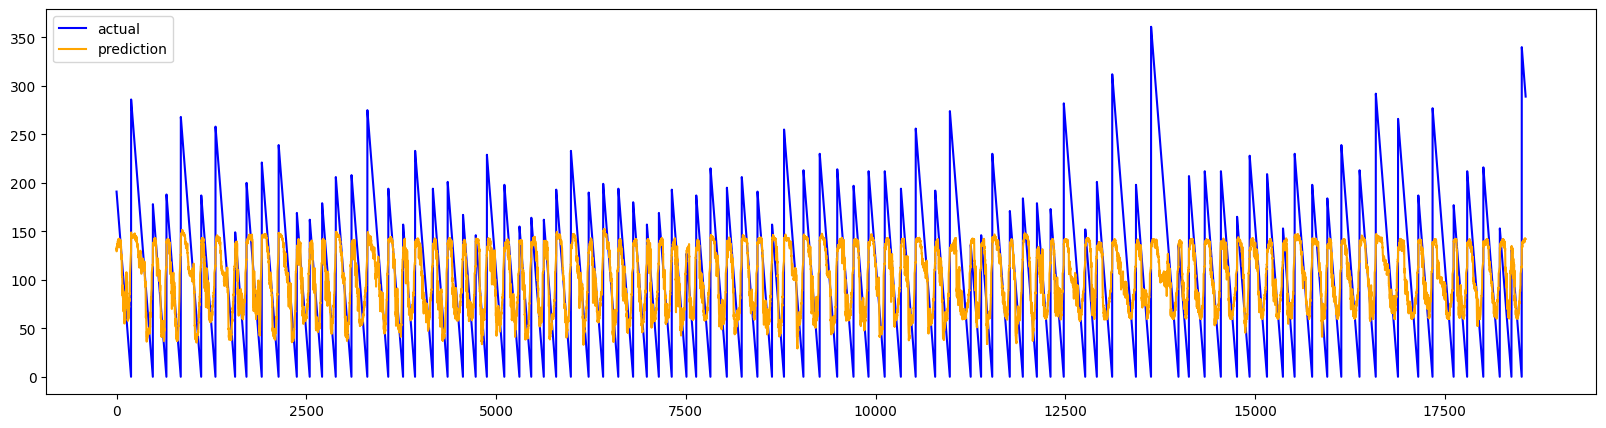

************Test*********
RMSE: 54.07
MAE: 40.59
r2 score: 0.16
MAPE: 33.30


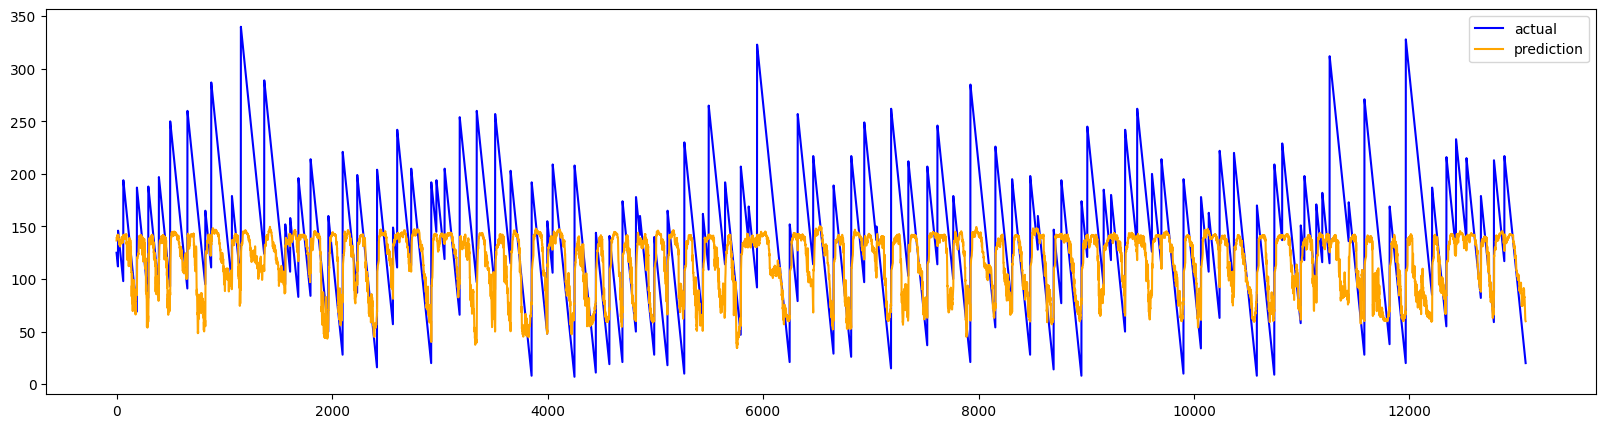

In [45]:
y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
y_train_inv = scaler_y.inverse_transform(y_train)
print("**********Train**********")
evaluate(y_train_inv, y_train_pred_inv)
plot_result(y_train_inv, y_train_pred_inv)

y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
print("************Test*********")
evaluate(y_test[window_size:], y_test_pred_inv)
plot_result(y_test[window_size:], y_test_pred_inv)


[64,128] lr: 0.01

In [47]:
y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
y_train_inv = scaler_y.inverse_transform(y_train)
print("**********Train**********")
evaluate(y_train_inv, y_train_pred_inv)
plot_result(y_train_inv, y_train_pred_inv)

y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
print("************Test*********")
evaluate(y_test[window_size:], y_test_pred_inv)
plot_result(y_test[window_size:], y_test_pred_inv)


**********Train**********
RMSE: 54.31
MAE: 40.43
r2 score: 0.35
MAPE: 242.08


************Test*********
RMSE: 55.17
MAE: 41.88
r2 score: 0.13
MAPE: 35.35


RMSE: 53.65
MAE: 39.40
r2 score: 0.37
MAPE: 229.13


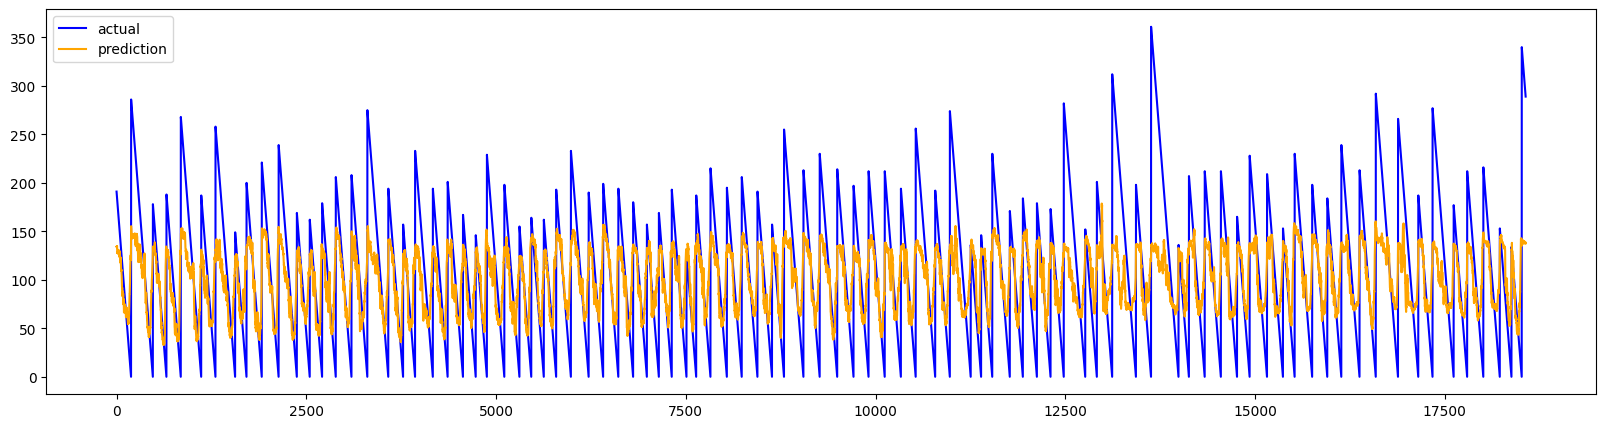

In [52]:
y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
y_train_inv = scaler_y.inverse_transform(y_train)
evaluate(y_train_inv, y_train_pred_inv)
plot_result(y_train_inv, y_train_pred_inv)

In [48]:
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
evaluate(y_test[window_size:], y_test_pred_inv)
plot_result(y_test[window_size:], y_test_pred_inv)

RMSE: 57.74
MAE: 42.94
r2 score: 0.04
MAPE: 34.89


dformer

In [42]:
# y_train_pred_inv = scaler_y.inverse_transform(predict(model, train_loader))
y_train_pred_inv = scaler_y.inverse_transform(predict(model, train_loader,device= device, model_name= 'TDCNN'))
y_train_inv = scaler_y.inverse_transform(y_train)
evaluate(y_train_inv, y_train_pred_inv)
plot_result(y_train_inv, y_train_pred_inv)

RMSE: 58.19
MAE: 44.75
r2 score: 0.26
MAPE: 242.18


tdcnn

In [48]:
# y_train_pred_inv = scaler_y.inverse_transform(predict(model, train_loader))
y_train_pred_inv = scaler_y.inverse_transform(predict(model, train_loader,device= device, model_name= 'TDCNN'))
y_train_inv = scaler_y.inverse_transform(y_train)
evaluate(y_train_inv, y_train_pred_inv)
plot_result(y_train_inv, y_train_pred_inv)

RMSE: 55.51
MAE: 41.19
r2 score: 0.32
MAPE: 249.30


cnn

MSE: 3136.99
MAE: 42.09
r2 score: 0.31
MAPE: 237.00


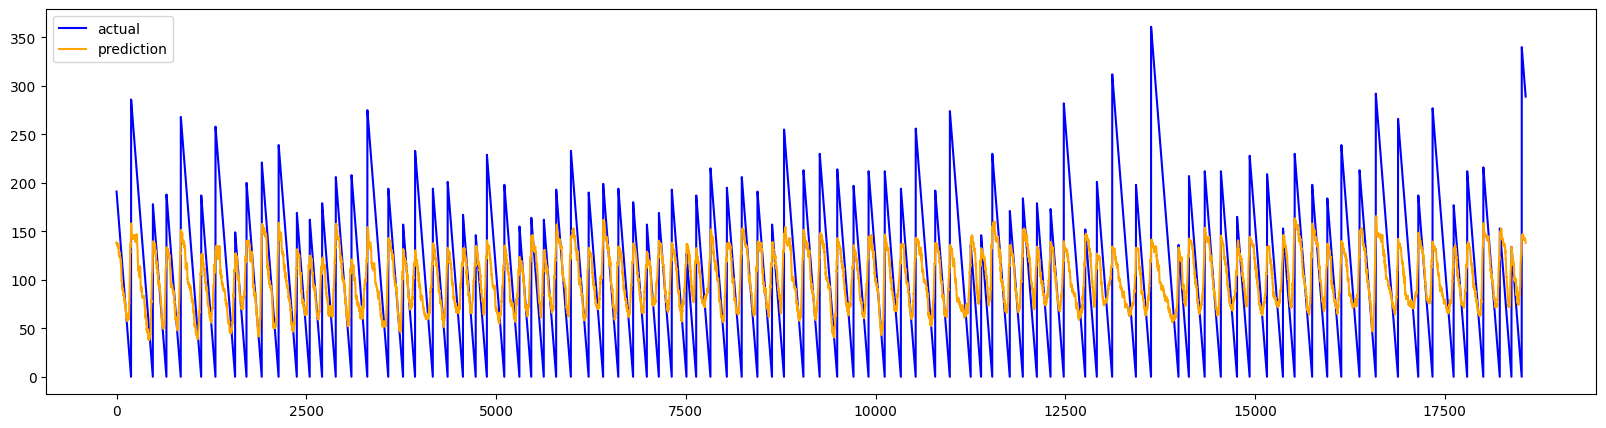

In [54]:
# y_train_pred_inv = scaler_y.inverse_transform(predict(model, train_loader))
y_train_pred_inv = scaler_y.inverse_transform(predict(model, train_loader,device= device, model_name= 'TDCNN'))
y_train_inv = scaler_y.inverse_transform(y_train)
evaluate(y_train_inv, y_train_pred_inv)
plot_result(y_train_inv, y_train_pred_inv)